# Setup

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi music21 pandas numpy matplotlib seaborn

In [ ]:
import pretty_midi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
import glob
from collections import defaultdict, Counter
from scipy.stats import skew, ttest_ind

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pretty_midi.pretty_midi.MAX_TICK = 1e10

Mounted at /content/drive


# File Paths

In [ ]:
def midi_to_notes(midi_file: str, max_duration=30.0) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

    # Process only notes that start before max_duration (30 seconds)
    for note in sorted_notes:
        if note.start > max_duration:
            break
        start = note.start
        end = min(note.end, max_duration)  # Limit the note end to max_duration
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - (notes['start'][-2] if len(notes['start']) > 1 else 0))
        notes['duration'].append(end - start)

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


def load_and_process_midis(midi_files):
    all_notes = []
    for midi_file in midi_files:
        notes_df = midi_to_notes(midi_file)
        all_notes.append(notes_df)
    return all_notes

# Plot Distributions

In [ ]:
def plot_distributions(notes: pd.DataFrame, title: str, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.suptitle(title)

    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))



def plot_total_distribution(all_notes,  title: str, drop_percentile=2.5):
    combined_notes = pd.concat(all_notes)
    plot_distributions(combined_notes, f'Total Distribution of {title} MIDI Files', drop_percentile)

def plot_average_distribution(all_notes, title: str, drop_percentile=2.5):
    combined_notes = pd.concat(all_notes)

    avg_notes = pd.DataFrame({
        'pitch': combined_notes.groupby(combined_notes.index).pitch.mean(),
        'step': combined_notes.groupby(combined_notes.index).step.mean(),
        'duration': combined_notes.groupby(combined_notes.index).duration.mean()
    })

    plt.figure(figsize=[15, 5])
    plt.suptitle(f'Average Distribution of {title} MIDI Files')

    plt.subplot(1, 3, 1)
    sns.histplot(avg_notes, x="pitch", bins=20)
    plt.xlabel('Average Pitch')

    plt.subplot(1, 3, 2)
    max_step = np.percentile(avg_notes['step'], 100 - drop_percentile)
    sns.histplot(avg_notes, x="step", bins=np.linspace(0, max_step, 21))
    plt.xlabel('Average Step')

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(avg_notes['duration'], 100 - drop_percentile)
    sns.histplot(avg_notes, x="duration", bins=np.linspace(0, max_duration, 21))
    plt.xlabel('Average Duration')

    plt.tight_layout()
    plt.show()



def plot_sample_distributions(num_samples=2, drop_percentile=2.5):
    for i in range(num_samples-1):

        random_index = random.randint(0,len(generated_midi_files)-1)

        plot_distributions(midi_to_notes(generated_midi_files[random_index]), f'Distribution of Generated MIDI File {generated_midi_files[random_index]}')
        plot_distributions(midi_to_notes(dataset_midi_files[random_index]), f'Distribution of Dataset MIDI File {dataset_midi_files[random_index]}')

# Plot Piano Roll

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count = None):

    title = f'Piano Roll of Sample Track'
    count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

def plot_average_piano_roll(all_notes,title: str):
    combined_notes = pd.concat(all_notes)
    avg_notes = pd.DataFrame({
        'pitch': combined_notes.groupby(combined_notes.index).pitch.mean(),
        'start': combined_notes.groupby(combined_notes.index).start.mean(),
        'end': combined_notes.groupby(combined_notes.index).end.mean()
    })
    title = f'Average {title} Piano Roll'
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([avg_notes['pitch'], avg_notes['pitch']], axis=0)
    plot_start_stop = np.stack([avg_notes['start'], avg_notes['end']], axis=0)
    plt.plot(
      plot_start_stop, plot_pitch, color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)
    plt.show()

# Standard Deviation and Variance

In [ ]:
def calculate_standard_deviation(notes_list):
    std_dev = {'pitch': [], 'step': [], 'duration': []}
    for notes in notes_list:
        std_dev['pitch'].append(notes['pitch'].std())
        std_dev['step'].append(notes['step'].std())
        std_dev['duration'].append(notes['duration'].std())

    avg_std_dev = {key: np.mean(values) for key, values in std_dev.items()}
    return avg_std_dev

def calculate_variance(notes_list):
    variance = {'pitch': [], 'step': [], 'duration': []}
    for notes in notes_list:
        variance['pitch'].append(notes['pitch'].var())
        variance['step'].append(notes['step'].var())
        variance['duration'].append(notes['duration'].var())

    avg_variance = {key: np.mean(values) for key, values in variance.items()}
    return avg_variance

# T-Test

In [ ]:
from scipy.stats import ttest_ind, skew

def perform_t_tests(notes_list1, notes_list2):
    results = {}

    for attribute in ['pitch', 'step', 'duration']:
        data1 = pd.concat([df[attribute] for df in notes_list1])
        data2 = pd.concat([df[attribute] for df in notes_list2])

        t_stat, p_value = ttest_ind(data1, data2)
        results[attribute] = {'t_stat': t_stat, 'p_value': p_value}

    return results

# Skewness

In [ ]:
def calculate_skewness(notes_list):
    skewness = {'pitch': [], 'step': [], 'duration': []}
    for notes in notes_list:
        skewness['pitch'].append(skew(notes['pitch']))
        skewness['step'].append(skew(notes['step']))
        skewness['duration'].append(skew(notes['duration']))

    avg_skewness = {key: np.mean(values) for key, values in skewness.items()}
    return avg_skewness

# Melody Detection (Little Bit Wacky)

In [ ]:
def detect_melodies(notes: pd.DataFrame, min_length=4, min_repeats=2):
    sequence = list(zip(notes['pitch'], notes['step']))
    subsequences = defaultdict(int)
    for i in range(len(sequence)):
        for j in range(i + min_length, len(sequence) + 1):
            subsequence = tuple(sequence[i:j])
            subsequences[subsequence] += 1
    melodies = {subseq: count for subseq, count in subsequences.items() if count >= min_repeats}
    return melodies

def get_total_melodies(notes_list):
    total_melodies = 0
    for notes in notes_list:
        melodies = detect_melodies(notes)
        total_melodies += len(melodies)
    return total_melodies

def get_average_melodies(notes_list,midi_files):
    return get_total_melodies(notes_list)/len(midi_files)

# Time Signature

In [ ]:
def plot_time_sg(midi_files,title:str):
    time_signatures = []
    for midi_file in midi_files:
        pm = pretty_midi.PrettyMIDI(midi_file)
        time_signature_changes = pm.time_signature_changes
        if time_signature_changes:
            time_signatures.extend([f"{ts.numerator}/{ts.denominator}" for ts in time_signature_changes])

    ts_counter = Counter(time_signatures)
    custom_ts_labels = ['2/4', '3/4', '4/4', '5/4', '6/8', '7/8', '12/8']
    ts_labels, counts = zip(*((ts, ts_counter.get(ts, 0)) for ts in custom_ts_labels))
    plt.figure(figsize=[15, 5])
    sns.barplot(x=ts_labels, y=counts)
    plt.xlabel('Time Signatures')
    plt.ylabel('Counts')
    plt.title(f'Time Signature {title} in MIDI Files')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
!cp -r  '/content/drive/MyDrive/:(/EE/bach_dataset' /content/
!cp -r  '/content/drive/MyDrive/:(/EE/bach_generated' /content/

dataset_midi_files = glob.glob('/content/bach_dataset/processed/*.mid')
generated_midi_files = glob.glob('/content/bach_generated/*.mid')

# Load Dataset and Generated MIDIs

In [ ]:
dataset_midi_files = dataset_midi_files[0:len(generated_midi_files)]
generated_notes = load_and_process_midis(generated_midi_files)
dataset_notes = load_and_process_midis(dataset_midi_files)

# Output

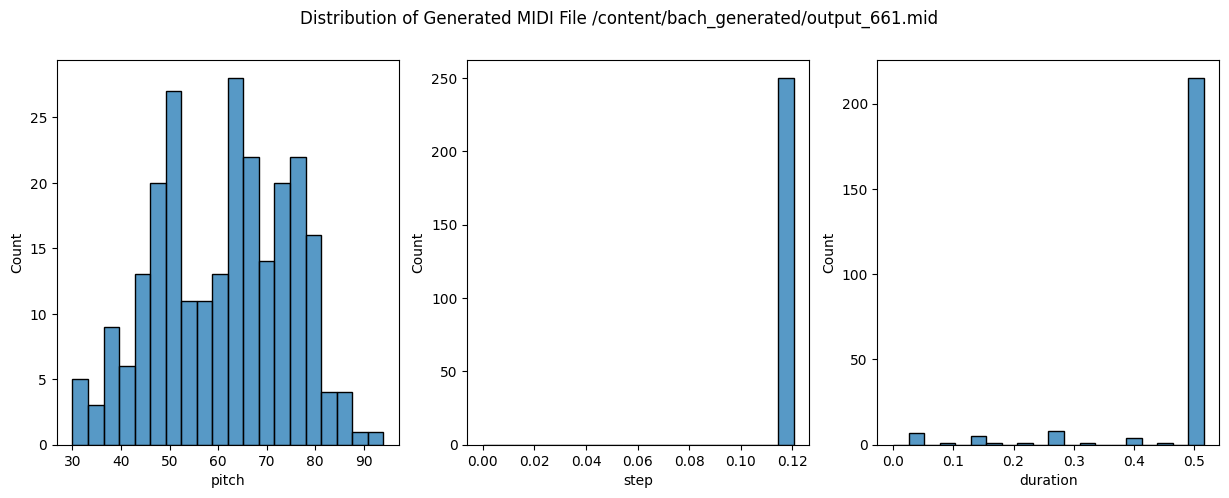

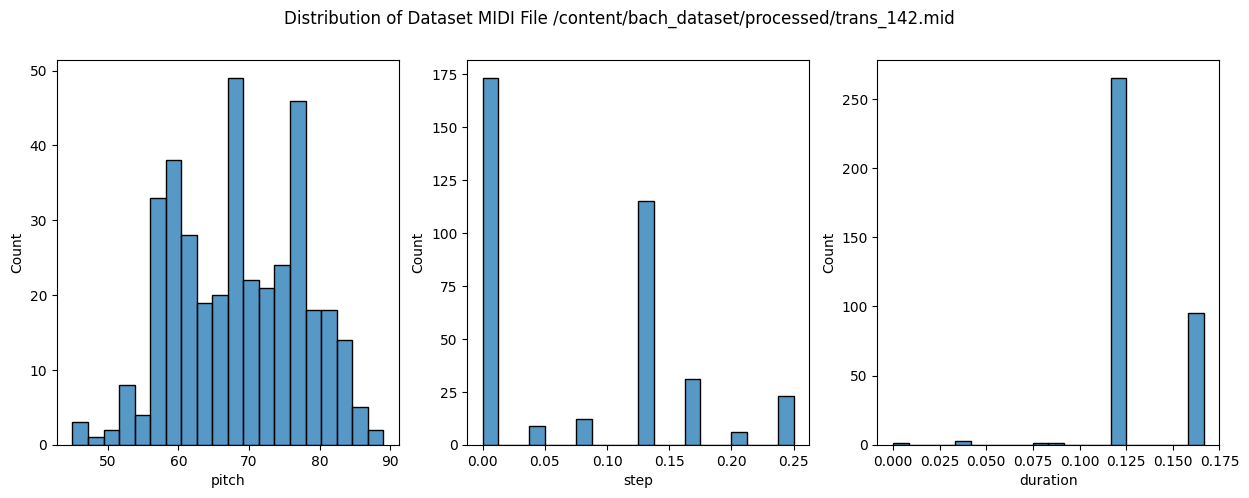

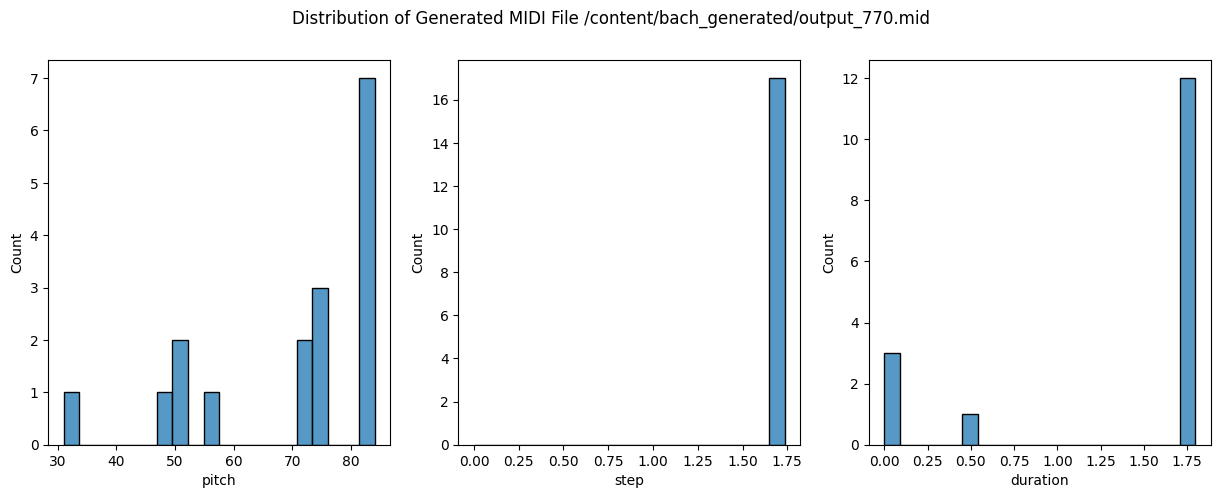

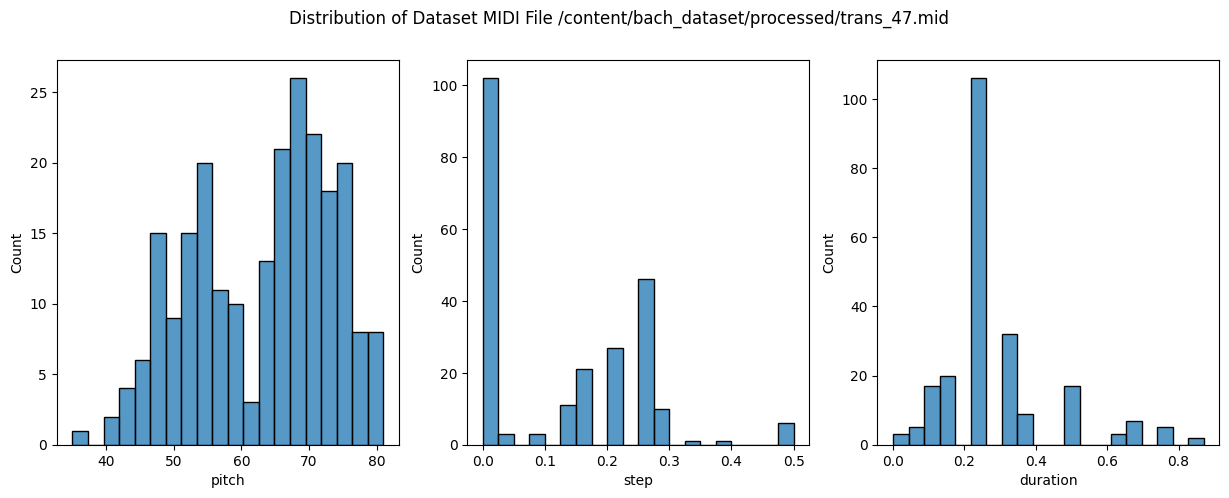

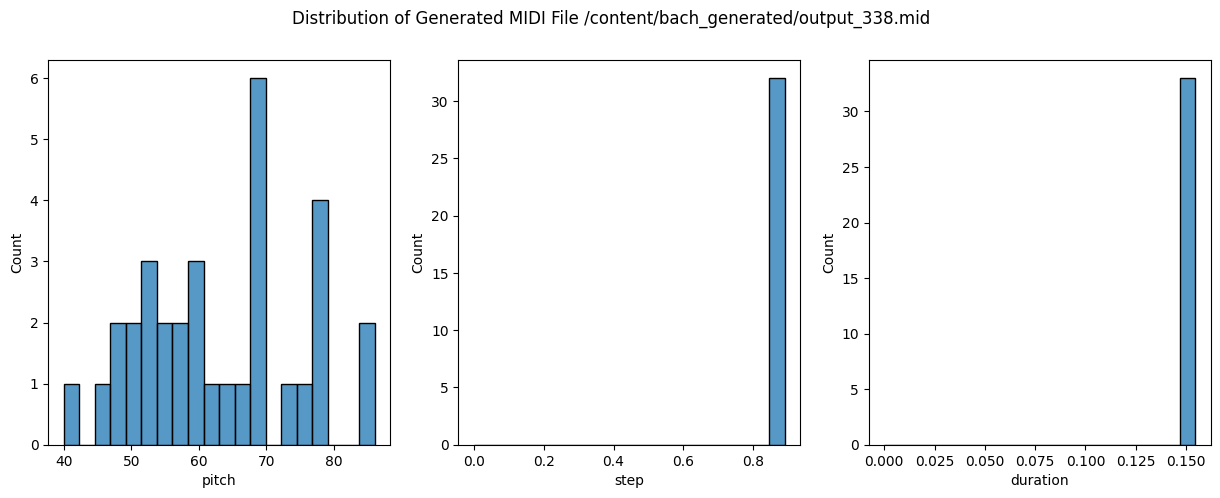

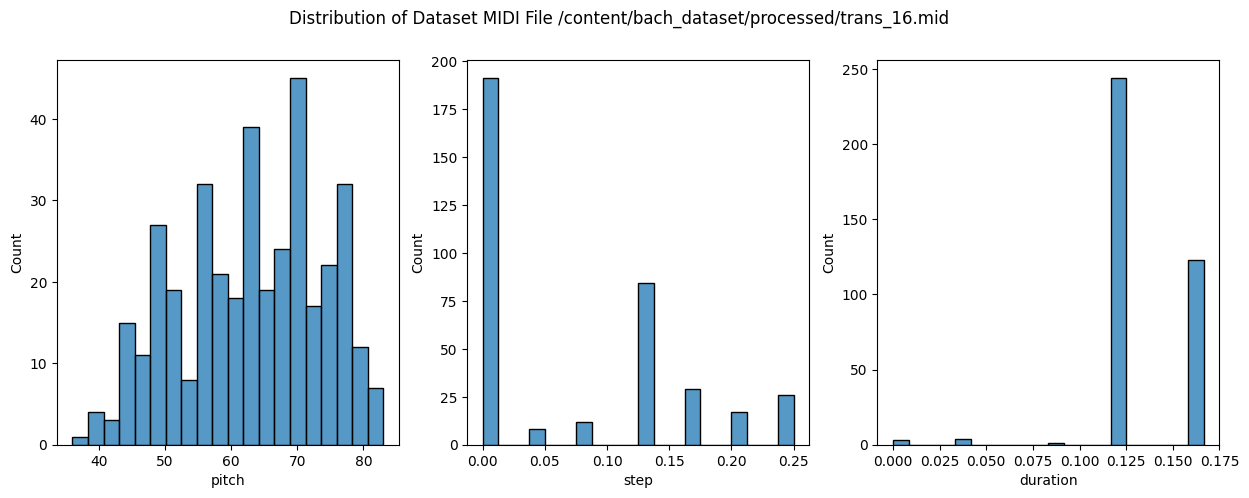

In [ ]:
plot_sample_distributions()
print("\n")
plot_sample_distributions()
print("\n")
plot_sample_distributions()

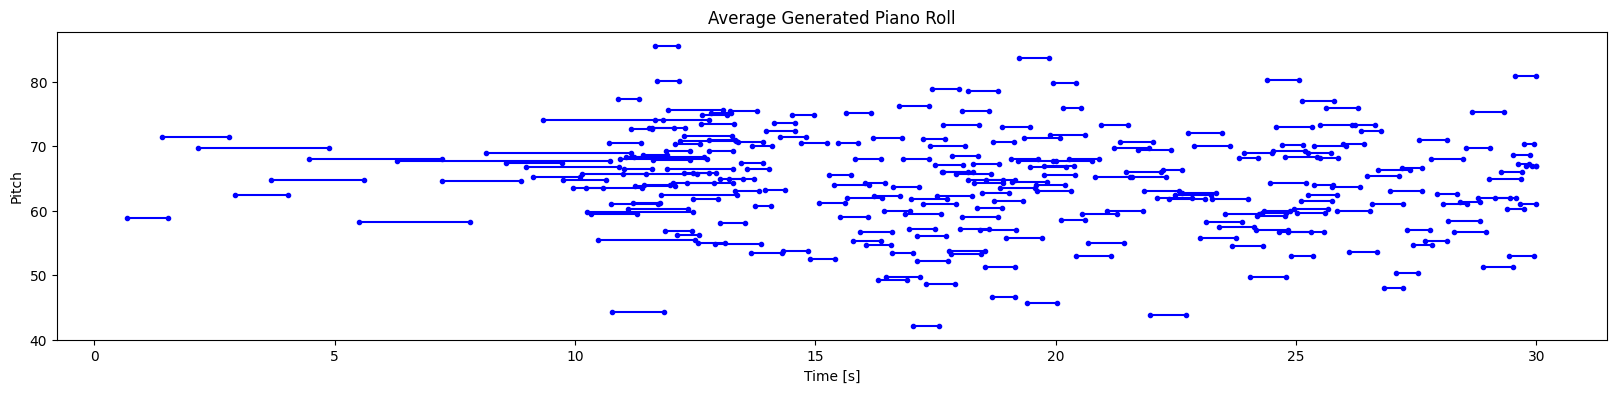

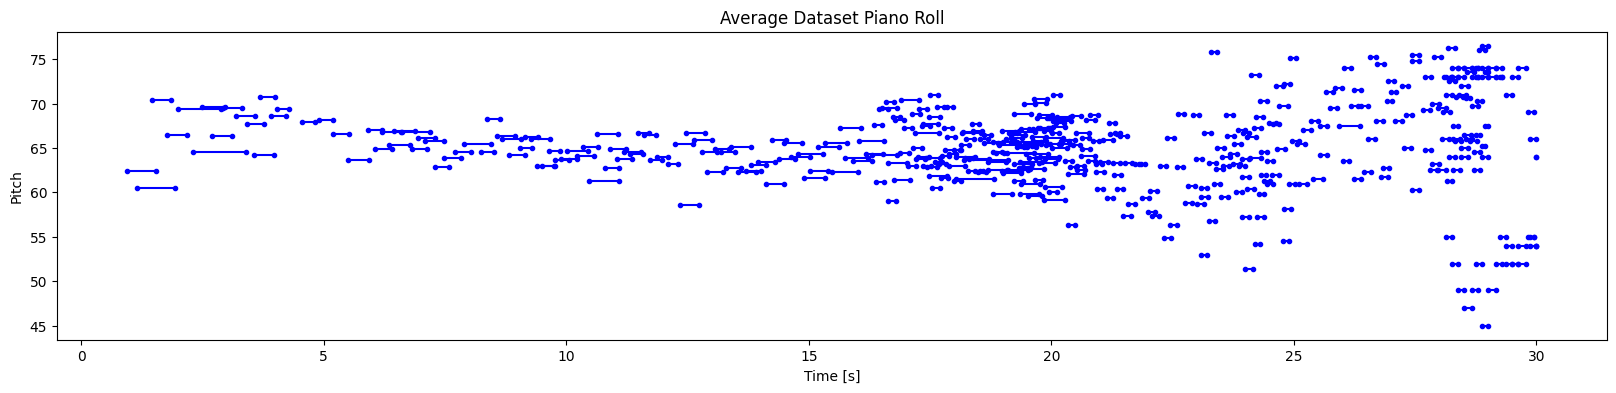

In [ ]:
plot_average_piano_roll(generated_notes,"Generated")
plot_average_piano_roll(dataset_notes, "Dataset")

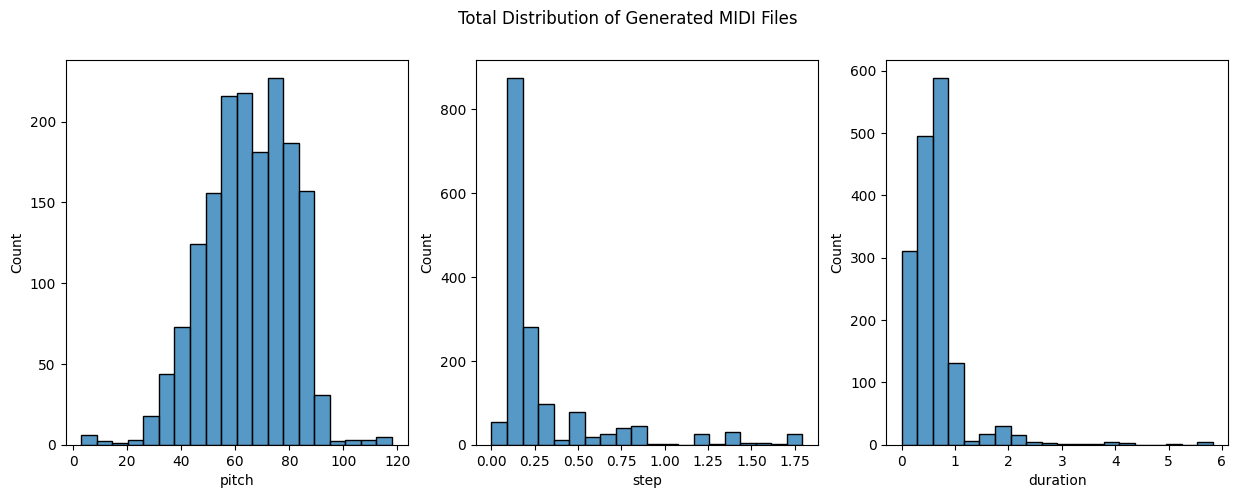

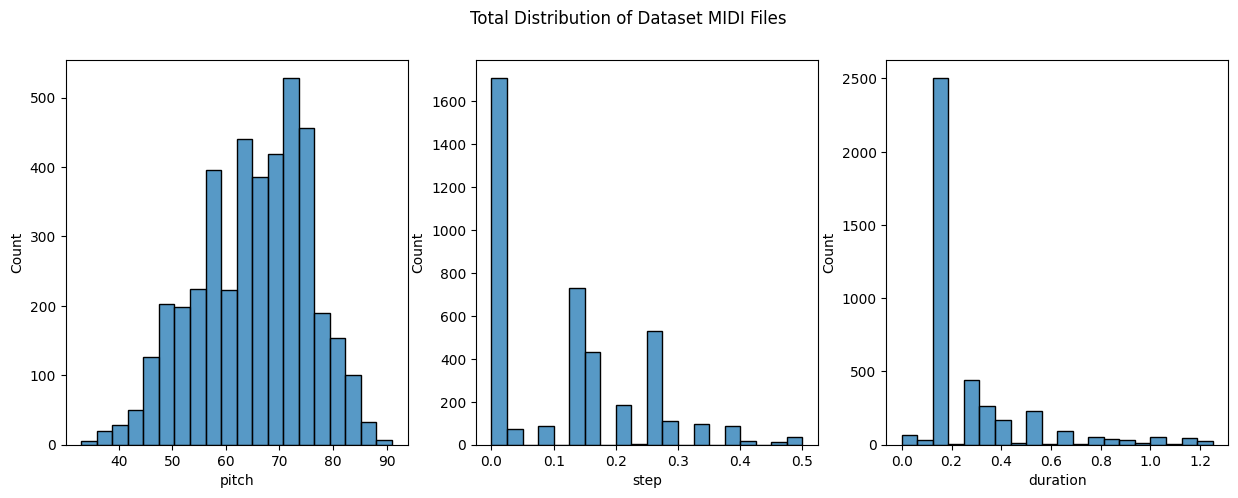

In [ ]:
plot_total_distribution(generated_notes,'Generated')
plot_total_distribution(dataset_notes, 'Dataset')

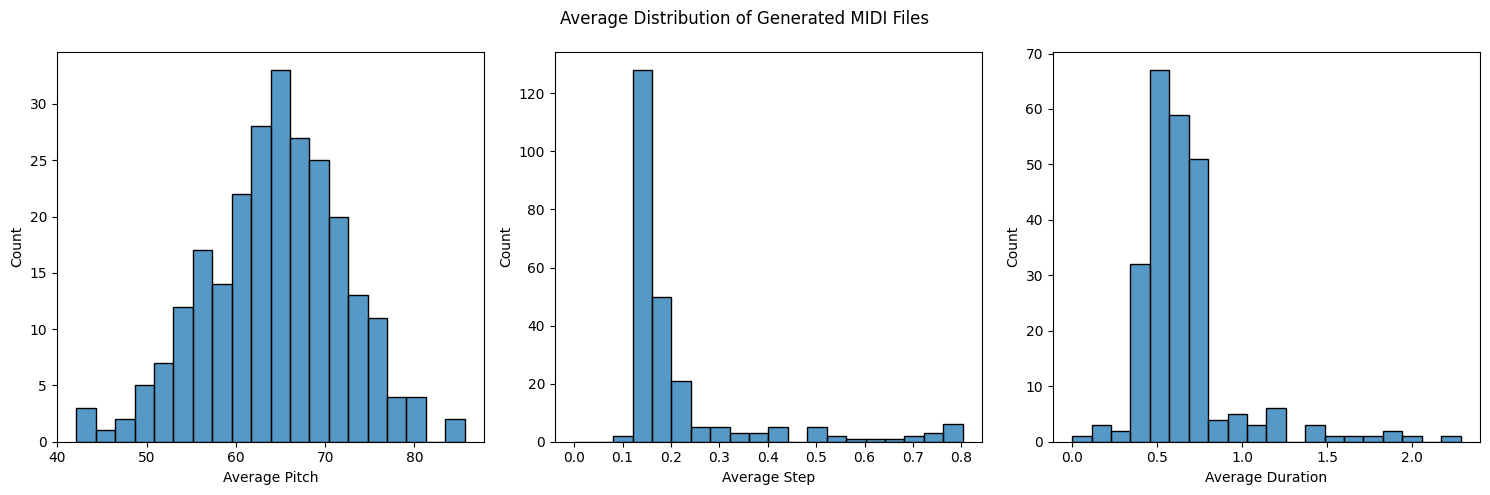

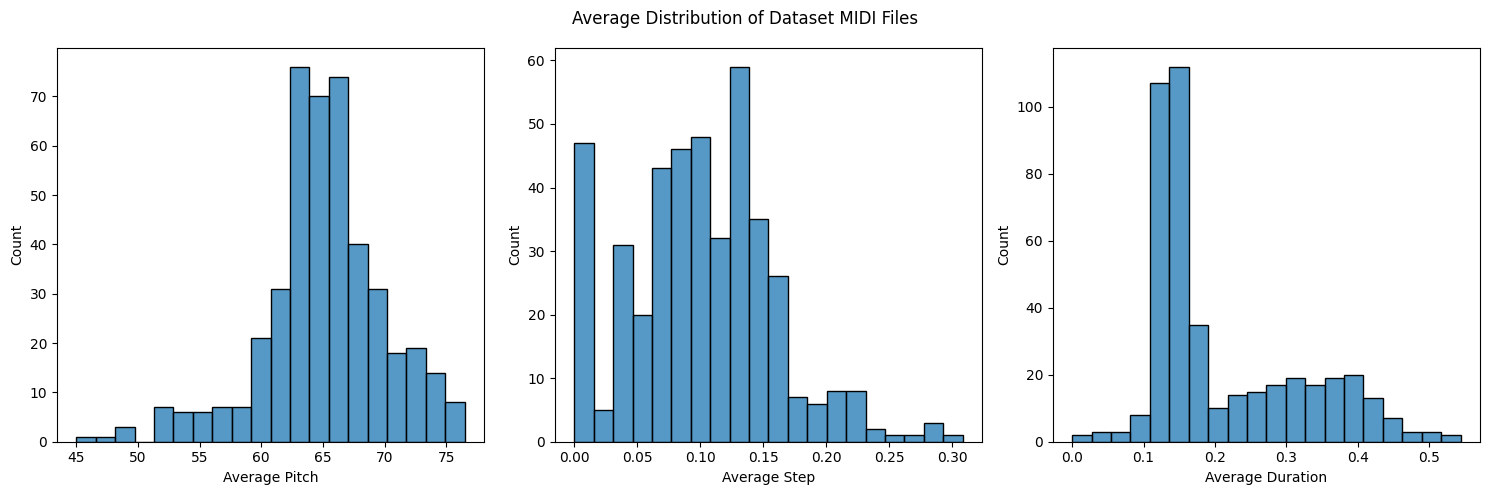

In [ ]:
plot_average_distribution(generated_notes,'Generated')
plot_average_distribution(dataset_notes, 'Dataset')

In [ ]:
t_test_results = perform_t_tests(generated_notes, dataset_notes)

for attribute, result in t_test_results.items():
    print(f"T-test for {attribute.capitalize()}:")
    print("t-statistic:", result['t_stat'], "p-value:", result['p_value'])
    print()

print(calculate_variance(generated_notes))
print(calculate_variance(dataset_notes))

T-test for Pitch:
t-statistic: -0.17376999327014317 p-value: 0.862052248174609

T-test for Step:
t-statistic: 21.041061249218604 p-value: 8.424830637451422e-95

T-test for Duration:
t-statistic: 17.37643164675759 p-value: 5.547632424007641e-66

{'pitch': 201.4451684411183, 'step': 0.21711457046144572, 'duration': 7.269537101851209}
{'pitch': 83.31057472642554, 'step': 0.1086294171045463, 'duration': 0.25905576422161464}


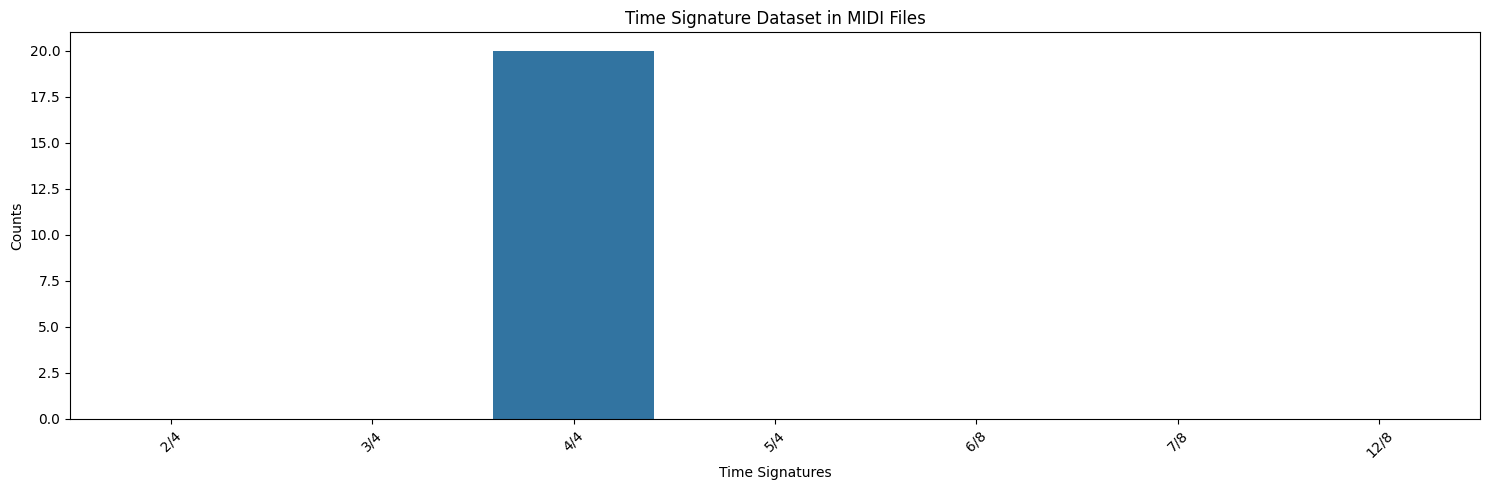

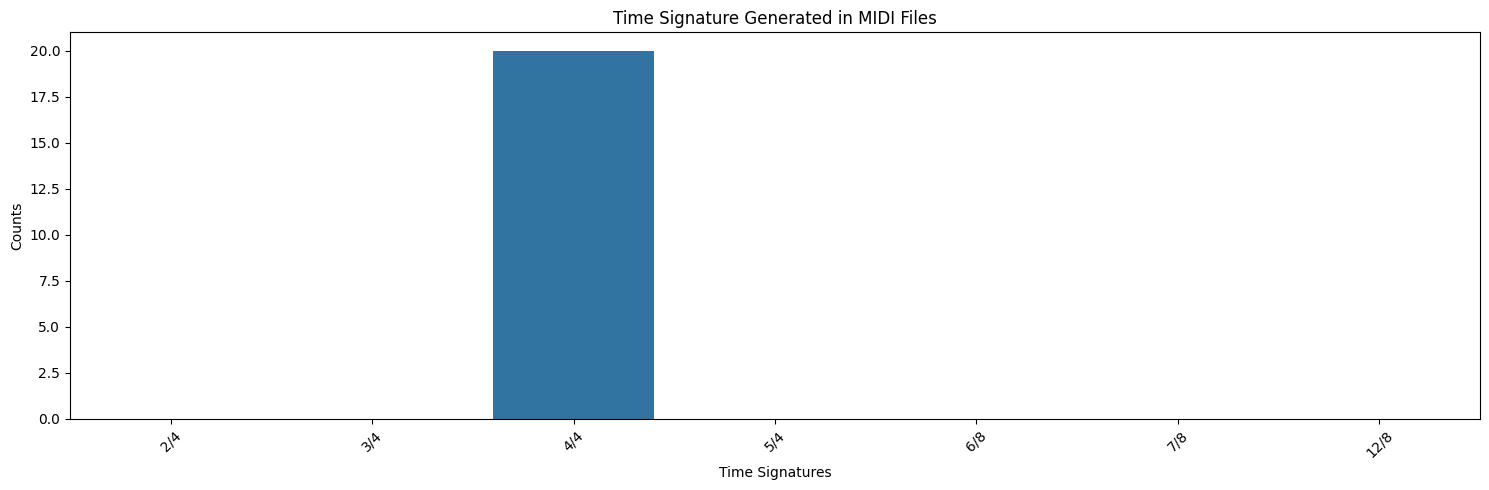

In [ ]:
plot_time_sg(dataset_midi_files,"Dataset")
plot_time_sg(generated_midi_files,"Generated")